In [48]:
##########################################################
# パッケージの読み込みとエイリアスの設定
##########################################################
using Revise, LinearAlgebra, LaTeXStrings, Plots, CSV, DataFrames, JLD2, Random, Statistics, Distributions
using TensorCrossInterpolation
import TensorCrossInterpolation as TCI
using Tensor_FixedSeedMC
import Tensor_FixedSeedMC as TCIMC

In [49]:
function tci_oneshot(func, d, localdims, firstpivot, tol, maxiter)
    BLAS.set_num_threads(4)
    #func_q = GenNDfunc(d, func)

    for isearch in 1:100
        p = TCI.optfirstpivot(func, localdims, firstpivot) # search optimal fist pivot
        if abs(func(p)) > abs(func(firstpivot))
            firstpivot = p
        end
    end

    # execute tci2
    qtt, ranks, errors = TCI.crossinterpolate2(
        Float64,
        func, 
        localdims, 
        [firstpivot], 
        tolerance = tol, 
        maxiter = maxiter, 
        verbosity = 1, 
        loginterval = 1,
        pivotsearch = :rook,
        # normalizeerror = false,
    )

    return qtt, errors
end  

tci_oneshot (generic function with 1 method)

In [50]:
##########################################################
# パラメータの設定とグリッド生成
##########################################################

#T = 1.0
#S0K = 110.0
#r = 0.05



Random.seed!(1234)
# d_normals = randn(Float64, N_STEPS * N_PATHS)

num_nodes = 64
index_ = Int(num_nodes/2)

S0K_values = TCIMC.calc_cheby_abscissas(90.0, 120.0, num_nodes)
implied_vol_values = TCIMC.calc_cheby_abscissas(0.15, 0.25, num_nodes)
#T_values = TCIMC.calc_cheby_abscissas(0.1, 1.0, num_nodes)
r_values = TCIMC.calc_cheby_abscissas(0.0, 0.1, num_nodes)
t_values = TCIMC.calc_cheby_abscissas(5.0, 10.0, num_nodes)

64-element Vector{Float64}:
 5.000752953259489
 5.006773858303275
 5.018801163503225
 5.036805894027647
 5.060744674903679
 5.0905598355114
 5.126179548517408
 5.167518002913153
 5.214475610741173
 5.266939247011212
 5.3247825222282215
 5.387866086875732
 5.456037967121041
 ⋮
 9.612133913124268
 9.675217477771778
 9.733060752988788
 9.785524389258827
 9.832481997086848
 9.873820451482592
 9.9094401644886
 9.939255325096322
 9.963194105972352
 9.981198836496775
 9.993226141696725
 9.99924704674051

$$
d_{1/2} = \frac{\ln{(S_0 / K)} + (r \pm \sigma^2 / 2)(T-t)}{\sigma \sqrt{T-t} }
$$

In [51]:
T = 1.0
d1(S0K::Float64, σ::Float64, r::Float64, t::Float64) = (log(S0K) + (r + σ^2/2) * (1.0 - t)) / (σ * (1.0 - t)^2)

function d1_ind_pre(
    bits::Vector{Int}, 
    S0K_values::Vector{Float64}, 
    implied_vol_values::Vector{Float64}, 
    r_values::Vector{Float64}, 
    t_values::Vector{Float64}
    )
    S0K = S0K_values[bits[1]]
    σ = implied_vol_values[bits[2]]
    r = r_values[bits[3]]
    t = t_values[bits[4]]
    return d1(S0K, σ, r, t)
end 

d1_ind(bits) = d1_ind_pre(bits, S0K_values, implied_vol_values, r_values, t_values)

d1_ind (generic function with 1 method)

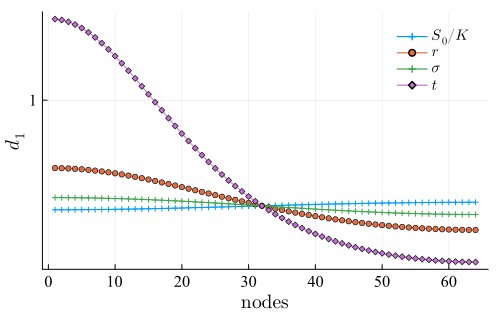

In [52]:
plot_d1 = plot(
    # yscale = :log,
    # xscale = :log,
    # title = L"\mathrm{QTT}~,~~d=10",
    xlabel = L"\mathrm{nodes}",
    ylabel = L"d_1",
    #markershape = :circle,
    titlefontsize = 17,
    legendfontsize = 10,
    tickfontsize = 10,
    xguidefont = 13,
    yguidefont = 13,
    #xlims = (0.6, 3.5),
    #xticks = 1:1:nbit*d-1,
    # ylims = (1, 2^(nbit*d*0.5)),
    yticks = [10^0, 10^2, 10^4, 10^6, 10^8],
    # legend = :inside,
    #size = (600, 450),
    #bottom_margin=Plots.Measures.Length(:mm, 3.0),
    bottom_margin=Plots.Measures.Length(:mm, 2.0),
    fontfamily = "Times New Roman",
    size = (500, 320),
    foreground_color_legend = nothing,
    background_color_legend = nothing,
)

plot!(
    plot_d1,
    [d1_ind([S0K_ind, index_, index_, index_]) for S0K_ind in 1:num_nodes],
    markershape = :auto,
    #seriestype = :scatter,
    #color = "red",
    markersize = 3,
    label = L"S_0 / K",
)

plot!(
    plot_d1,
    [d1_ind([index_, r_ind, index_,  index_]) for r_ind in 1:num_nodes],
    markershape = :auto,
    #seriestype = :scatter,
    #color = "red",
    markersize = 3,
    label = L"r",
)

plot!(
    plot_d1,
    [d1_ind([index_, index_, σ_ind, index_]) for σ_ind in 1:num_nodes],
    markershape = :auto,
    #seriestype = :scatter,
    #color = "red",
    markersize = 3,
    label = L"\sigma",
)


plot!(
    plot_d1,
    [d1_ind([index_, index_, index_, t_ind]) for t_ind in 1:num_nodes],
    markershape = :auto,
    #seriestype = :scatter,
    #color = "red",
    markersize = 3,
    label = L"t",
)

In [53]:
##########################################################
# TCI のキャッシュ関数設定とワンショット補間の実行
##########################################################
# 関数 abo は asian_barrier_option_tci のラッパー（引数はインデックス）
#abo(j) = asian_barrier_option_tci(j, price_matrix_mc)
# abo_(j) = asian_barrier_option_tci(j, price_matrix_mc)

d = 4
localdims_d1 = fill(num_nodes, d)
firstpivot_d1 = rand(1:num_nodes, d)
d1_cf = TCI.CachedFunction{Float64}(d1_ind, localdims_d1)
tol_mc = 1e-5
tol = tol_mc
maxiter = 10

tci_time = @elapsed begin
    tt_tci, errors_asianbarrier = tci_oneshot(d1_cf, d, localdims_d1, firstpivot_d1, tol, maxiter)
end

##########################################################

Found 0 global pivots
iteration = 1, rank = 3, error= 0.0, maxsamplevalue= 1.9750481544010234, nglobalpivot=0
Found 0 global pivots
iteration = 2, rank = 3, error= 0.0, maxsamplevalue= 1.9750481544010234, nglobalpivot=0
Found 0 global pivots
iteration = 3, rank = 3, error= 0.0, maxsamplevalue= 1.9750481544010234, nglobalpivot=0


0.017642167

In [54]:
tt_tci.sitetensors

4-element Vector{Array{Float64, 3}}:
 [0.0 0.0013953443893300888 … 0.9989530321435117 1.0;;; 1.0 0.9986046556106701 … 0.0010469678564899692 0.0]
 [1.0 0.9982948008576021 … 0.0009037162557756292 0.0; 0.0 -0.0009031362112937869 … -0.5994818741582876 -0.6000963838230078;;; 0.0 3.5686731347794876e-14 … -1.2490009027033011e-15 0.0; 1.0 0.9991979370689299 … 0.600385590414058 0.6000963838230107;;; 0.0 0.0015049852584100108 … 0.9989759817235145 1.0; 0.0 0.0015049852584107756 … 0.9989759817235166 0.9999999999999948]
 [1.0 0.998875430143684 … 0.06751811972577892 0.066393549869464; 0.933606450130535 0.9324818802742189 … 0.0011245698563150386 0.0; 0.4880456128955799 0.4873707625914493 … -0.07153339143746418 -0.07220824174159601;;; 0.0 0.001196443161220377 … 0.992078493256692 0.993274936417911; 0.0067250635820903185 0.007921506743310696 … 0.998803556838781 1.0; 0.11921213949728529 0.11993012071178223 … 0.7145548557692095 0.7152728369837078]
 [1.9750481544010234 1.9690887093079537 … 0.38623172342970

In [55]:
# TCI後のTTを評価
n = num_nodes
price_matrix_tci_S0K = zeros(n)
price_matrix_ex_S0K = zeros(n)
price_matrix_tci_sigma = zeros(n)
price_matrix_ex_sigma = zeros(n)
price_matrix_tci_r = zeros(n)
price_matrix_ex_r = zeros(n)
price_matrix_tci_t = zeros(n)
price_matrix_ex_t = zeros(n)


for i in 1:n
    price_matrix_tci_S0K[i] = TCIMC._evaluate(tt_tci.sitetensors, [i, index_, index_, index_, index_])
    price_matrix_ex_S0K[i] = d1_ind([i, index_, index_, index_, index_])
    price_matrix_tci_sigma[i] = TCIMC._evaluate(tt_tci.sitetensors, [index_, i, index_, index_, index_])
    price_matrix_ex_sigma[i] = d1_ind([index_, i, index_, index_, index_])
    price_matrix_tci_r[i] = TCIMC._evaluate(tt_tci.sitetensors, [index_, index_, i, index_, index_])
    price_matrix_ex_r[i] = d1_ind([index_, index_, i, index_, index_])
    price_matrix_tci_t[i] = TCIMC._evaluate(tt_tci.sitetensors, [index_, index_, index_, i])
    price_matrix_ex_t[i] = d1_ind([index_, index_, index_, i])
end

ab_error_S0K = abs.(price_matrix_tci_S0K .- price_matrix_ex_S0K)
ab_error_sigma = abs.(price_matrix_tci_sigma .- price_matrix_ex_sigma)
ab_error_r = abs.(price_matrix_tci_r .- price_matrix_ex_r)
an_error_t = abs.(price_matrix_tci_t .- price_matrix_ex_t)
rel_error_S0K = abs.(price_matrix_tci_S0K .- price_matrix_ex_S0K) ./ price_matrix_ex_S0K
rel_error_sigma = abs.(price_matrix_tci_sigma .- price_matrix_ex_sigma) ./ price_matrix_ex_sigma
rel_error_r = abs.(price_matrix_tci_r .- price_matrix_ex_r) ./ price_matrix_ex_r
rel_error_t = abs.(price_matrix_tci_t .- price_matrix_ex_t) ./ price_matrix_ex_t



println("==== TCI ====")
println("Max absolute error for S0K    : ", maximum(ab_error_S0K))
println("Max absolute error for sigma  : ", maximum(ab_error_sigma))
println("Max absolute error for r      : ", maximum(ab_error_r))
println("Max absolute error for t      : ", maximum(an_error_t))
println("Max relative error for S0K    : ", maximum(rel_error_S0K))
println("Max relative error for sigma  : ", maximum(rel_error_sigma))
println("Max relative error for r      : ", maximum(rel_error_r))
println("Max absolute error for t      : ", maximum(an_error_t))
:

==== TCI ====
Max absolute error for S0K    : 2.7755575615628914e-16
Max absolute error for sigma  : 2.220446049250313e-16
Max absolute error for r      : 1.6653345369377348e-16
Max absolute error for t      : 2.220446049250313e-16
Max relative error for S0K    : 5.623764561109041e-16
Max relative error for sigma  : 5.460562156002838e-16
Max relative error for r      : 3.448559292603498e-16
Max absolute error for t      : 2.220446049250313e-16


(::Colon) (generic function with 30 methods)

In [56]:
TCI.TensorTrain(tt_tci)

(::TensorTrain{Float64, 3}) (generic function with 1 method)

In [57]:
M_dct = TCIMC.dct_matrix(n)
C_coeff_tensor_tci = TCIMC.compute_chebyshev_coeff(TCI.TensorTrain(tt_tci), fill(M_dct, d))
#C_coeff_tensor_svd = TCIMC.compute_chebyshev_coeff(TCI.TensorTrain(tt_svd), fill(M_dct, 2))

(::TensorTrain{Float64, 3}) (generic function with 1 method)

In [58]:
# TT( G_k ∈ ℝ^{r_{k-1} × n_k × r_k} ) と
# v_modes = [v₁, v₂, ..., v_d]（各 v_k ∈ ℝ^{n_k}）の内積。
# ここで v は v₁ ⊗ v₂ ⊗ ... ⊗ v_d の分離形を仮定。
function tt_inner(tt_cores::Vector{<:Array{T,3}}, v_modes::Vector{<:AbstractVector{T}}) where {T<:Real}
    d = length(tt_cores)
    @assert d == length(v_modes) "次元数が一致しません: length(tt_cores)=$(d) vs length(v_modes)=$(length(v_modes))"

    # r₀ = 1 なので (1, r₀) から開始
    res = ones(T, 1, size(tt_cores[1], 1))

    for k in 1:d
        G = tt_cores[k]                            # (r_{k-1}, n_k, r_k)
        n_k = size(G, 2)
        @assert n_k == length(v_modes[k]) "第$(k)モードのサイズ不一致: n_k=$(n_k) vs length(v_modes[k])=$(length(v_modes[k]))"

        # 次の (1, r_k) を溜めるバッファ
        tmp = zeros(T, size(res, 1), size(G, 3))

        # 各 i_k について res * G[:, i_k, :] * v_k[i_k] を加算
        @inbounds for i in 1:n_k
            Gi = view(G, :, i, :)                  # (r_{k-1}, r_k)
            tmp .+= res * Gi * v_modes[k][i]
        end

        res = tmp                                  # (1, r_k)
    end

    @assert size(res, 2) == 1 "最終ランク r_d は1である必要がありますが、r_d=$(size(res,2))"
    return res[1]                                   # スカラー
end


tt_inner (generic function with 1 method)

### 不明点

In [59]:
using Statistics, Random

#num_nodes = n
# num_nodes_S0 = 300
num_nodes_cheby = 64
S0K_values_equiv = collect(range(90.0, stop=120.0, length=num_nodes_cheby))
implied_vol_values_equiv = collect(range(0.15, stop=0.25, length=num_nodes_cheby))
#T_values_equiv = collect(range(0.1, stop=1.0, length=num_nodes_cheby))
r_values_equiv = collect(range(0.0, stop=0.1, length=num_nodes_cheby))
t_values_equiv = collect(range(5.0, stop=10.0, length=num_nodes_cheby))

# 全インデックスの組を作成して、ランダムに100点抽出
Random.seed!(1234)
# all_idx_pairs = [(i, j, k, l, m) for i in 1:num_nodes, j in 1:num_nodes, k in 1:num_nodes, l in 1:num_nodes, m in 1:num_nodes]
all_idx_pairs = collect(Iterators.product(1:num_nodes_cheby, 1:num_nodes_cheby, 1:num_nodes_cheby, 1:num_nodes_cheby))
rand_idx_pairs = rand(vec(all_idx_pairs), 10)

# 解析解の関数
d1_ind_ex(bits) = d1_ind_pre(bits, S0K_values_equiv, implied_vol_values_equiv, r_values_equiv, t_values_equiv)
#d1_ind_ex(bits) = d1_ind_pre(bits, S0K_values, implied_vol_values, T_values, r_values, t_values)


price_dict_tci = Dict{NTuple{4, Int}, Float64}()

price_dict_ex = Dict{NTuple{4, Int}, Float64}()

for (i, j, k, l) in rand_idx_pairs
    s0_val   = S0K_values_equiv[i]
    vol_val  = implied_vol_values_equiv[j]
    r_val    = r_values[k]
    t_val    = t_values[l]

    weights = [
        TCIMC.chebyshev_basis(90.0, 120.0, s0_val, num_nodes_cheby),
        TCIMC.chebyshev_basis(0.15, 0.25, vol_val, num_nodes_cheby),
        TCIMC.chebyshev_basis(0.0, 0.1, r_val, num_nodes_cheby),
        TCIMC.chebyshev_basis(5.0, 10.0, t_val, num_nodes_cheby)
    ]

    c = 1  # 初期コアから更新
    #left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
    #right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
    #result_original = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)
    result_original = tt_inner(C_coeff_tensor_tci.sitetensors, weights)

    # TCI
    price_dict_tci[(i, j, k, l)] = result_original
    # 解析解
    #price_dict_ex[(i, j, k, l)] = d1_ind_ex([i, j, k, l])
    price_dict_ex[(i, j, k, l)] = d1(s0_val, vol_val, r_val, t_val)
end



In [60]:
@show price_dict_ex
@show price_dict_tci
;

price_dict_ex = Dict((7, 23, 39, 23) => 0.7645433715232516, (30, 59, 9, 36) => 0.3796270273786724, (5, 54, 15, 58) => 0.22617483917009215, (55, 36, 59, 51) => 0.253591968719164, (33, 33, 58, 48) => 0.2716349654647862, (44, 56, 15, 26) => 0.5771496248590879, (54, 13, 56, 21) => 0.9275891521268065, (58, 64, 64, 61) => 0.17859902179139472, (41, 29, 41, 32) => 0.510819157046351, (12, 22, 64, 14) => 1.0709154514945385)
price_dict_tci = Dict((7, 23, 39, 23) => 0.7645433715232456, (30, 59, 9, 36) => 0.37962702737867116, (5, 54, 15, 58) => 0.2261748391700903, (55, 36, 59, 51) => 0.2535919687191605, (33, 33, 58, 48) => 0.2716349654647816, (44, 56, 15, 26) => 0.5771496248590895, (54, 13, 56, 21) => 0.9275891521268013, (58, 64, 64, 61) => 0.17859902179139434, (41, 29, 41, 32) => 0.510819157046356, (12, 22, 64, 14) => 1.070915451494526)


### 誤差評価

In [61]:
using Statistics

# 絶対誤差、相対誤差を保存する辞書
abs_errors_tci = Dict{Tuple{Int,Int,Int,Int},Float64}()
rel_errors_tci = Dict{Tuple{Int,Int,Int,Int},Float64}()

for key in keys(price_dict_tci)
    ex_val = price_dict_ex[key]
    tci_val = price_dict_tci[key]
    abs_err = abs(ex_val - tci_val)
    rel_err = abs_err / abs(ex_val) 
    abs_errors_tci[key] = abs_err
    rel_errors_tci[key] = rel_err
end

# 統計量を計算
abs_error_vals = collect(values(abs_errors_tci))
rel_error_vals = collect(values(rel_errors_tci))

@show abs_error_vals
@show rel_error_vals

println("==== cheby ====")
println("Mean absolute error   : ", mean(abs_error_vals))
println("Max  absolute error   : ", maximum(abs_error_vals))
println("Mean relative error   : ", mean(rel_error_vals))
println("Max  relative error   : ", maximum(rel_error_vals))

abs_error_vals = [1.2434497875801753e-14, 1.2212453270876722e-15, 1.8596235662471372e-15, 3.497202527569243e-15, 4.6074255521944e-15, 1.5543122344752192e-15, 5.218048215738236e-15, 3.885780586188048e-16, 5.10702591327572e-15, 5.995204332975845e-15]
rel_error_vals = [1.1611092041345121e-14, 3.2169609617112376e-15, 8.222062069639094e-15, 1.3790667524814868e-14, 1.6961827960221452e-14, 2.6930836780058674e-15, 5.625387278165259e-15, 2.1757009345362903e-15, 9.997718062896214e-15, 7.84154902949612e-15]
==== cheby ====
Mean absolute error   : 4.188316360398403e-15
Max  absolute error   : 1.2434497875801753e-14
Mean relative error   : 8.213604954083152e-15
Max  relative error   : 1.6961827960221452e-14
